# COM calculation
## Load all tiffs in scan folder, average, plot centre of mass of residuals in 2D

In [2]:
import tifffile as tif
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass as com
from scipy.optimize import curve_fit
import os
from scipy.signal import detrend
import scipy.io as sio
from tqdm import tqdm_notebook
from scipy.stats import norm
import matplotlib.mlab as mlab

In [3]:
%matplotlib inline

#Needs to follow inline magick command
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 32
plt.rcParams['image.cmap'] = 'viridis'

## Change following variables as required

In [10]:
imgsperpt=1 #Acquisitions per scan point
ny, nx=201,101 #Scan dimensions
scan_number=107
path='/CNMshare/savedata/2018R3/20181002/Images/%d/'  %scan_number #Scan path
#path = '../%d/' %scan_number

#ROI of data you want to analyze
roix1=256
roix2=roix1+224
roiy1=165
roiy2=roiy1+182

detx,dety=512,512

save_figs_yes_no = 1 #Save 2D maps and/or histograms?
sav_figs_path = '../figs' #Where to save images

In [16]:
files=sorted(os.listdir(path))
nfiles=len(files)
npts=ny*nx
print ("Npts", npts)


data=np.zeros((npts,roiy2-roiy1,roix2-roix1),float)
i,j=0,0
for fl in tqdm_notebook(files):
    data[i,:,:]=tif.imread(path+fl)[roiy1:roiy2,roix1:roix2]
    j+=1
    if(j%imgsperpt==0): i+=1
    if(i>=npts): break
print (i,j, data.shape)

Npts 20301


20294 20294 (20301, 182, 224)


## Plot average intensity and ith frame

In [17]:
avg_intens=np.average(data, axis=0)

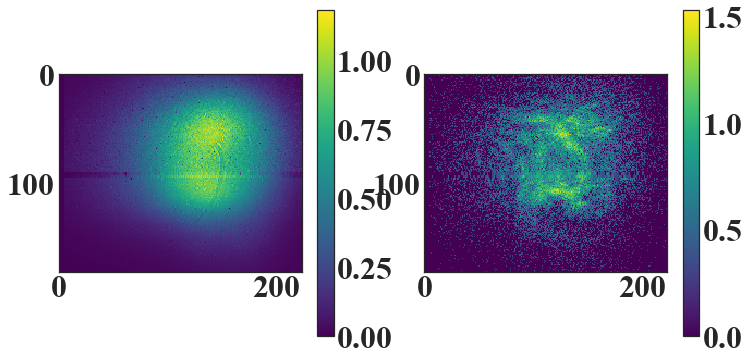

In [18]:
i=0
figs,ax=plt.subplots(1,2,figsize=(12,6))
im=ax[0].imshow(np.log10(avg_intens+1))
plt.colorbar(im,ax=ax[0])
im=ax[1].imshow(np.log10(data[0]+1))
plt.colorbar(im,ax=ax[1])

## Subtract average detector image from each frame

In [19]:
data2=data-avg_intens
data2=data

## Plot data after subtracting average from each frame

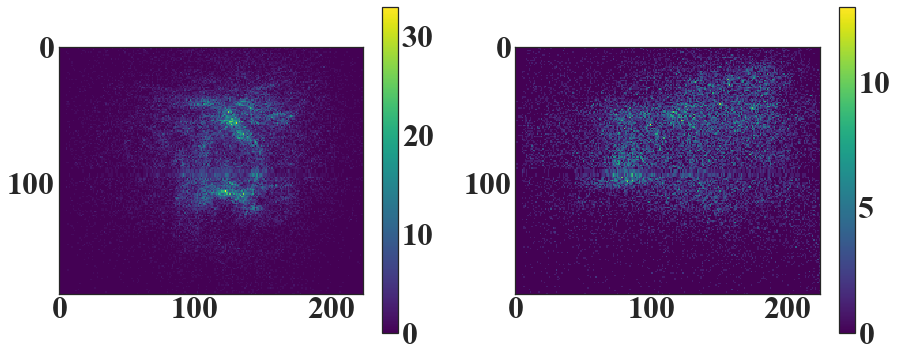

In [20]:
i,j=0,400
figs,ax=plt.subplots(1,2,figsize=(15,6))
im=ax[0].imshow(data2[i])
plt.colorbar(im,ax=ax[0])
im=ax[1].imshow(data2[j])
plt.colorbar(im,ax=ax[1])

## Calculate centre of masses, subtract the COM of the first image
### All centroid shift is now relative to average

In [21]:
use_subtracted_data=1 #Whether to use frame (minus) average data or not

In [39]:
coms=np.zeros((npts,2),float)
zero_frames=[]
for i in range(npts):
    if(data[i,:,:].any()>0):
        if(use_subtracted_data): coms[i,:]=np.asarray(com(data2[i,:,:]))
        else: coms[i,:]=np.asarray(com(data[i,:,:]))
    else:
        print('Frame %d is all 0' %(i+1))
        zero_frames.append(i)

print (coms[0], coms[400])
#coms-=coms[0,:]

#Set COM of missing frames to the average
for i in zero_frames:
    coms[i,0], coms[i,1]= np.average(coms[:,0]), np.average(coms[:,1])

print ("Average COMs:", np.average(coms[:,0]), np.average(coms[:,1]))

print ("Max COMs:", np.max(coms[:,0]), np.max(coms[:,1]))
    
#Move average COM shift to 0
for i in range (2):
    coms[:,i]-=np.average(coms[:,i])

print (coms[0], coms[400])

Frame 20295 is all 0
Frame 20296 is all 0
Frame 20297 is all 0
Frame 20298 is all 0
Frame 20299 is all 0
Frame 20300 is all 0
Frame 20301 is all 0
[ 76.59603196 123.62998859] [ 70.30703612 125.9156799 ]
Average COMs: 74.51994759727012 132.94076831976136
Max COMs: 123.00567803383508 189.90424403686646
[ 2.07608436 -9.31077973] [-4.21291148 -7.02508842]


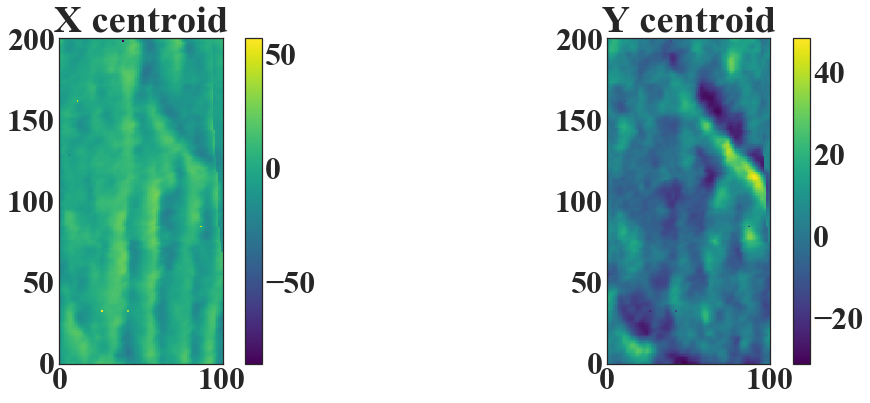

In [40]:
coms=coms.reshape(ny,nx,2)
figs,ax=plt.subplots(1,2,figsize=(18,6))
im=ax[0].imshow(coms[:,:,1], origin='lower') #CAREFUL: Rows is Y
plt.colorbar(im,ax=ax[0])
ax[0].set_title("X centroid")

im=ax[1].imshow(coms[:,:,0], origin='lower')
plt.colorbar(im,ax=ax[1])
ax[1].set_title("Y centroid")
if(save_figs_yes_no):
    plt.savefig('%s/%d_maps.png' %(sav_figs_path,scan_number), dpi=300)

## Detrend and plot if so required

In [24]:

#tmp2=detrend(coms[:,:,1], axis=0)
#im=ax[1].imshow(tmp2)
#plt.colorbar(im,ax=ax[1])
#ax[1].set_title("Detrended")

In [25]:
#sio.savemat('raw_data.mat', {'data':data})

-1.478416095685268e-14 9.29621071452347


/Users/user26id/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


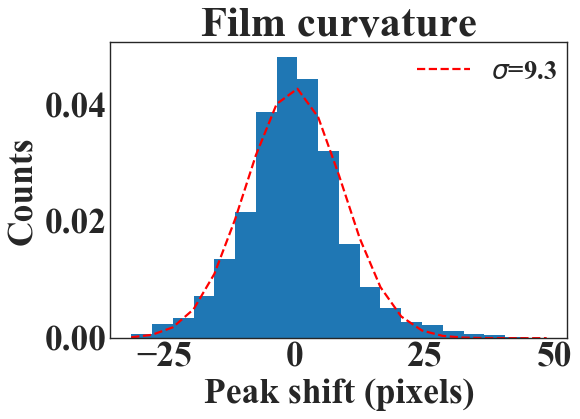

In [41]:
(mu, sigma) = norm.fit(coms[:,:,1].ravel())
print (mu, sigma)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

n, bins, patches=plt.hist(coms[:,:,0].ravel(), bins=20, density=1)

y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2, label=r'$\sigma$=%.1f' %sigma)

plt.xlabel("Peak shift (pixels)")
plt.ylabel("Counts")
plt.title("Film curvature")
plt.legend(loc='right', bbox_to_anchor=(1.03, 0.9), fontsize=24)
plt.tight_layout()
if(save_figs_yes_no):
    plt.savefig('%s/%d_hist.png' %(sav_figs_path,scan_number), dpi=300)